In [1]:
from simulation import *
from aesthetics import *
from models import *
from data import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)

In [3]:
import pandas as pd
import scipy as sc
import os as os
import re as re

In [4]:
this = simulation()

In [5]:
this.name = 'psiSER311'

In [86]:
this.simulate()

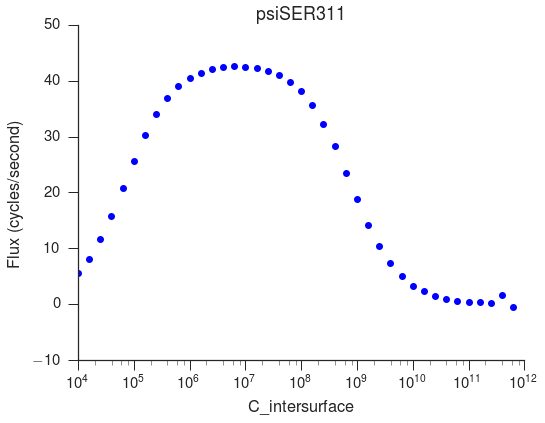

In [8]:
name = 'psiSER311'
fig = plt.figure(figsize=(8,6), dpi=300)
ax = fig.add_subplot(111)
for scaling in np.arange(4, 12, 0.2):
    this = simulation()
    this.name = name
    this.C_intersurface = 10**scaling
    this.simulate()
    ax.errorbar(this.C_intersurface, np.mean(this.flux_u + this.flux_b), sc.stats.sem(this.flux_u + this.flux_b), 
                fmt='o', c='b')
    del this
    
ax.set_xlabel('C\\_intersurface')
ax.set_ylabel('Flux (cycles/second)')
ax.set_title(name)
ax.set_xscale('log')
fetching_plot(fig, ax)

/home/dslochower/recovery-fund/SG-model-v2/simulation.py:256: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


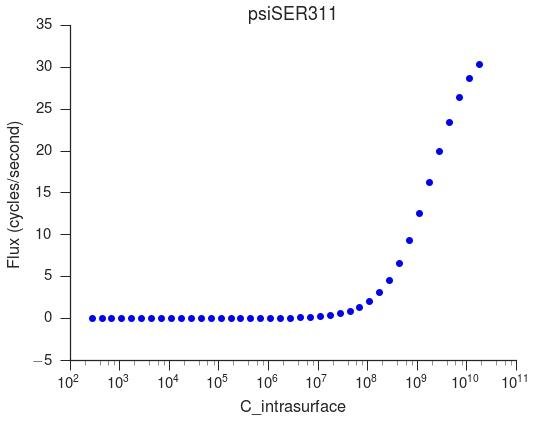

In [7]:
name = 'psiSER311'
fig = plt.figure(figsize=(8,6), dpi=300)
ax = fig.add_subplot(111)
for scaling in np.arange(4, 12, 0.2):
    this = simulation()
    this.name = name
    this.C_intrasurface_0 = 10**scaling
    this.simulate()
    ax.errorbar(this.C_intrasurface, np.mean(this.flux_u + this.flux_b), sc.stats.sem(this.flux_u + this.flux_b), 
                fmt='o', c='b')
    del this
    
ax.set_xlabel('C\\_intrasurface')
ax.set_ylabel('Flux (cycles/second)')
ax.set_title(name)
ax.set_xscale('log')
fetching_plot(fig, ax)

In [32]:
df = pd.DataFrame()

In [40]:
for file in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        pass
    else:
        this = simulation()
        this.name = name
        this.simulate()
        flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_with_catalysis_sem = sc.stats.sem(this.flux_u + this.flux_b)
        
        this.catalytic_rate = 0
        this.simulate()
        flux_without_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_without_catalysis_sem = sc.stats.sem(this.flux_u + this.flux_b)
  
        df = df.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                                'Flux with catalysis SEM': flux_with_catalysis_sem,
                                'Flux without catalysis': flux_without_catalysis,
                                'Flux without catalysis SEM': flux_without_catalysis_sem,
                                'File': name,
                                'Ratio': flux_with_catalysis / flux_without_catalysis,
                                }, index=[0]), ignore_index=True)

/Users/davids/Desktop/Recovery/simulation.py:256: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ss = ss / np.sum(ss)


In [42]:
df['Ratio'] = df['Flux with catalysis'] / df['Flux without catalysis']

In [45]:
df.sort_values('Flux with catalysis').head()

,File,Flux with catalysis,Flux with catalysis SEM,Flux without catalysis,Flux without catalysis SEM,Ratio
367,chi2GLU194,-53.820771,0.007337,0.031726,0.009115,-1696.448024
193,chi1PHE171,-43.298662,0.059157,-0.791530,0.068149,54.702504
788,phiGLY273,-35.995070,0.004906,-0.061973,0.006333,580.818636
186,chi1MET44,-26.511099,0.028184,0.732416,0.134587,-36.196783
72,chi1GLU194,-25.049377,0.003796,0.015008,0.005184,-1669.078750


In [46]:
df.to_pickle('Flux-results.pickle')

In [16]:
def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x - mu)**2/(2. * sigma**2))

def fit_gaussian(bin_centers, histogram, *p):
    from scipy.optimize import curve_fit
    coefficients, variance = curve_fit(gaussian, bin_centers, histogram, p0=p[0])
    return coefficients, variance

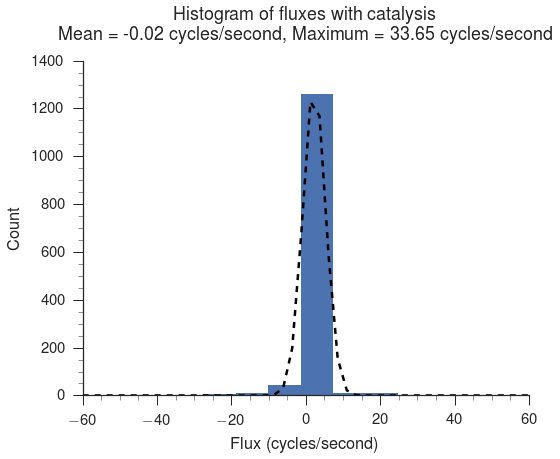

In [98]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(df['Flux with catalysis'], bins=10)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coefficients, variance = fit_gaussian(center, hist, [1, 0, 1])

ax.bar(center, hist, align='center', width=width, edgecolor=None, lw=0)
fit_points = np.linspace(-60, 60, 50)
ax.plot(fit_points, gaussian(fit_points, *coefficients), c='k', ls='--',
        label=r'$\\mu = ${0:0.2f}, $\\sigma = ${1:0.2f}'.format(coefficients[1], coefficients[2]))

plt.xlabel('Flux (cycles/second)')
plt.ylabel('Count')
ax.set_title('Histogram of fluxes with catalysis\n Mean = {0:0.2f} cycles/second, Maximum = {1:0.2f} cycles/second'.format(np.mean(df['Flux with catalysis']),
             df['Flux with catalysis'].max()), y=1.05)
fetching_plot(fig, ax)

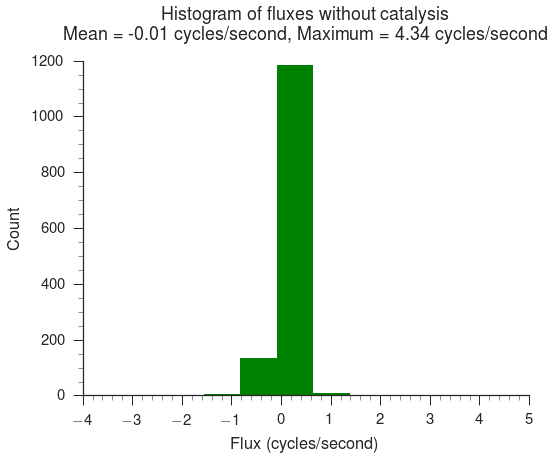

In [24]:
df = pd.read_pickle('Flux-results.pickle')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(df['Flux without catalysis'], bins=10)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coefficients, variance = fit_gaussian(center, hist, [1, 0, 1])

ax.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='g')
fit_points = np.linspace(1, 1, 50)
ax.plot(fit_points, gaussian(fit_points, *coefficients), c='k', ls='--',
        label=r'$\\mu = ${0:0.2f}, $\\sigma = ${1:0.2f}'.format(coefficients[1], coefficients[2]))

plt.xlabel('Flux (cycles/second)')
plt.ylabel('Count')
ax.set_title('Histogram of fluxes without catalysis\n Mean = {0:0.2f} cycles/second, Maximum = {1:0.2f} cycles/second'.format(np.mean(df['Flux without catalysis']),
             df['Flux without catalysis'].max()), y=1.05)
fetching_plot(fig, ax)

In [26]:
df.sort_values(by='Flux without catalysis', ascending=False)

,File,Flux with catalysis,Flux with catalysis SEM,Flux without catalysis,Flux without catalysis SEM,Ratio
565,chi3GLU194,-17.566290,4.947506,4.344967,4.102530,-4.042905
489,chi2PHE173,1.018207,0.442578,2.013144,0.343071,0.505780
124,chi1LEU153,-0.300068,0.069173,1.085067,0.240346,-0.276543
105,chi1ILE232,5.189272,0.131569,0.996056,0.121881,5.209819
711,phiASN312,0.270734,0.109660,0.930181,0.109561,0.291055
128,chi1LEU191,-12.443692,0.056826,0.779567,0.100437,-15.962308
186,chi1MET44,-26.511099,0.028184,0.732416,0.134587,-36.196783
4,chi1ARG151,24.574252,0.045719,0.709663,0.070110,34.628067
80,chi1GLU327,1.390996,0.038850,0.695270,0.074252,2.000655
102,chi1ILE196,1.353210,0.051308,0.681820,0.079811,1.984702


In [14]:
df_symmetrized_data = pd.DataFrame()
dir = 'reversed-and-averaged'
for file in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        pass
    else:
        this = simulation()
        this.name = name
        # Override the popluations
        this.unbound_population = np.genfromtxt(dir + '/apo/' + name + '_chi_pop_hist_targ.txt', delimiter=',',
                                               skip_header=1)
        this.bound_population = np.genfromtxt(dir + '/atpmg/' + name + '_chi_pop_hist_ref.txt', delimiter=',',
                                               skip_header=1)
        
        this.simulate(pka_md_data=False)
        flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_with_catalysis_sem = sc.stats.sem(this.flux_u + this.flux_b)
  
        df_symmetrized_data = df_symmetrized_data.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                                'Flux with catalysis SEM': flux_with_catalysis_sem,
                                }, index=[0]), ignore_index=True)

/home/dslochower/recovery-fund/SG-model-v2/simulation.py:256: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


In [19]:
df_symmetrized_data.to_pickle('Flux-symmetrized-data-results.pickle')

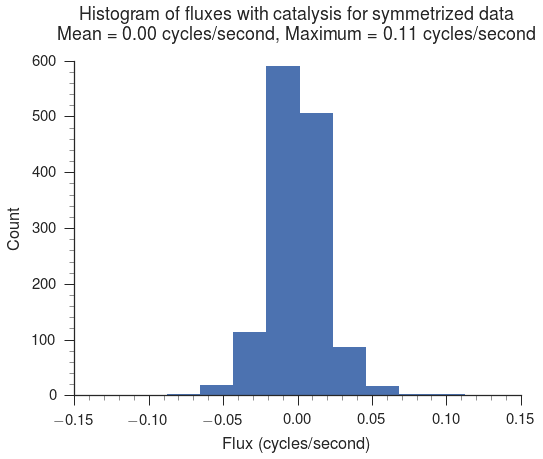

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(df_symmetrized_data['Flux with catalysis'], bins=10)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coefficients, variance = fit_gaussian(center, hist, [1, 0, 1])

ax.bar(center, hist, align='center', width=width, edgecolor=None, lw=0)
fit_points = np.linspace(-60, 60, 50)
#ax.plot(fit_points, gaussian(fit_points, *coefficients), c='k', ls='--',
#        label=r'$\\mu = ${0:0.2f}, $\\sigma = ${1:0.2f}'.format(coefficients[1], coefficients[2]))

plt.xlabel('Flux (cycles/second)')
plt.ylabel('Count')
ax.set_title('Histogram of fluxes with catalysis for symmetrized data\n Mean = {0:0.2f} cycles/second, Maximum = {1:0.2f} cycles/second'.format(np.mean(df_symmetrized_data['Flux with catalysis']),
             df_symmetrized_data['Flux with catalysis'].max()), y=1.05)
fetching_plot(fig, ax)

In [101]:
df['ResID'] = df['File'].str.extract('(\\d+$)')

/Users/davids/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [103]:
filename = 'residues-by-flux'
attribute = 'flux'

file = str(filename) + '.dat'
f = open(file, 'w')
f.write('attribute: {}\n'.format(attribute))
f.write('match mode: 1-to-1\n')
f.write('recipient: residues\n')
for i in range(1, max(df['ResID'].astype(int))):
    x = np.max(abs(df[df['ResID'] == str(i)]['Flux with catalysis']))
    f.write('\t:{}\t{}\n'.format(i, x))
f.close()

In [104]:
def data_frame_to_chimera(df, df_index_column, df_target_column, filename, chimera_label):
    file = str(filename) + '.dat'
    f = open(file, 'w')
    f.write('attribute: {}\n'.format(chimera_label))
    f.write('match mode: 1-to-1\n')
    f.write('recipient: residues\n')
    for i in range(1, max(df[df_index_column].astype(int))):
        x = np.max(abs(df[df[df_index_column] == str(i)][df_target_column]))
        f.write('\t:{}\t{}\n'.format(i, x))
    f.close()

In [105]:
data_frame_to_chimera(df, 'ResID', 'Ratio', 'residues-by-flux-ratio', 'flux-ratio')

# Still need:
- [x] Reversed and averaged MD data
    - [x] Plotting information is in `fetching`
- [] Diffusion explanations
    - [] I think we can copy butane-rotational-diffusion from another source
    - [] C-intrasurface-derivation
    - [] diffusion-coefficient-and-C-intrasurface
- [] `figures-for-paper` (which is basically this document)
    - [x] McCLendon's PDB files
- [] 50DG-toy-model
